### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.



In [186]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [190]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [191]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [192]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v0.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(46500, 41)

(4444, 41)

(4403, 41)

count    46500.000000
mean       167.403097
std         10.350122
min        149.000000
25%        159.000000
50%        168.000000
75%        176.000000
max        184.000000
Name: prd, dtype: float64

count    4444.000000
mean      185.997525
std         0.816079
min       185.000000
25%       185.000000
50%       186.000000
75%       187.000000
max       187.000000
Name: prd, dtype: float64

count    4403.000000
mean      188.997956
std         0.818208
min       188.000000
25%       188.000000
50%       189.000000
75%       190.000000
max       190.000000
Name: prd, dtype: float64

Number of features before transformation:  (46500, 38)
time to do feature proprocessing: 
Number of features after transformation:  (46500, 84) (4444, 84) (4381, 84) (4403, 84)
mae of a constant model 7.989002798117338
R2 of a constant model 0.0
fixed XGB train: 7.2936517680386475 0.08209972933431675
XGB val: 9.333257547436476 0.021046069322619876
XGB val extra: 7.449474573984752 0.005638548266455157
XGB test: 10.509277917328513 0.026280919917970325
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.025436589972033352 51.93192768096924
XGB train: 7.241671823627634 0.09783003114377553
XGB validation: 8.837739464119451 0.1338705926983017
XGB validation extra: 6.983415793741495 0.1367766827196445
XGB test: 10.455126096822962 0.03312929656455288


[I 2022-09-06 20:51:48,768] A new study created in memory with name: no-name-0791c416-b55d-4ec9-8fbe-b5481d6847f8
[I 2022-09-06 20:51:50,588] Trial 0 finished with value: 0.008695445757376002 and parameters: {'n_estimators': 1321, 'max_depth': 2, 'learning_rate': 0.008543277591917918, 'colsample_bytree': 0.4826539390861307, 'subsample': 0.45123474333775115, 'alpha': 0.15741726997599043, 'lambda': 138.14047179649938, 'gamma': 1.9753679652102876e-07, 'min_child_weight': 4.311908185048308}. Best is trial 0 with value: 0.008695445757376002.
[I 2022-09-06 20:51:53,487] Trial 1 finished with value: -0.008619362201395614 and parameters: {'n_estimators': 1098, 'max_depth': 5, 'learning_rate': 0.014836051651947764, 'colsample_bytree': 0.36577267476235287, 'subsample': 0.7929507854517949, 'alpha': 11.065871947901467, 'lambda': 35.10346003519957, 'gamma': 0.04324630515088469, 'min_child_weight': 1.2257751491668623}. Best is trial 0 with value: 0.008695445757376002.
[I 2022-09-06 20:51:58,068] Tri

Total time for hypermarameter optimization  45.674782514572144
        n_estimators : 1485
           max_depth : 2
       learning_rate : 0.008546464832335733
    colsample_bytree : 0.0546830919112066
           subsample : 0.31375904203463284
               alpha : 1.6759904606680893
              lambda : 0.10066796469305248
               gamma : 12.312742622675936
    min_child_weight : 0.13824448620284924
best objective value : 0.016040971312241352
Optuna XGB train: 
 7.461428321428935 0.03342392051862897 
validation 
 9.215158870463663 0.04908183313470171 7.33259025879932 0.024970401869853665 
test 
 10.525828801484554 0.015595611257659514


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.033424,0.049082,0.015596
1,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(79162, 41)

(6405, 41)

(6311, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    6405.000000
mean      285.996565
std         0.816362
min       285.000000
25%       285.000000
50%       286.000000
75%       287.000000
max       287.000000
Name: prd, dtype: float64

count    6311.000000
mean      288.997782
std         0.816235
min       288.000000
25%       288.000000
50%       289.000000
75%       290.000000
max       290.000000
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 58.72147870063782
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997


[I 2022-09-06 20:53:43,166] A new study created in memory with name: no-name-90ef594e-1b7b-4a7d-bd76-37c8b088c7b5
[I 2022-09-06 20:53:44,028] Trial 0 finished with value: -0.004044818114926419 and parameters: {'n_estimators': 905, 'max_depth': 5, 'learning_rate': 0.025019136230489958, 'colsample_bytree': 0.35916139438456635, 'subsample': 0.7592572890572913, 'alpha': 4.146564363554224, 'lambda': 0.9384009960330469, 'gamma': 2.1122572523780342e-06, 'min_child_weight': 2.339375964301839}. Best is trial 0 with value: -0.004044818114926419.
[I 2022-09-06 20:53:44,828] Trial 1 finished with value: -0.0025380838569263263 and parameters: {'n_estimators': 1020, 'max_depth': 6, 'learning_rate': 0.011358354707639356, 'colsample_bytree': 0.9202013585354419, 'subsample': 0.6318990606656083, 'alpha': 3.4422831871519124, 'lambda': 33.73278951999262, 'gamma': 31.860945804547008, 'min_child_weight': 5.144990748366948}. Best is trial 1 with value: -0.0025380838569263263.
[I 2022-09-06 20:53:45,267] Tria

Total time for hypermarameter optimization  10.76462459564209
        n_estimators : 825
           max_depth : 3
       learning_rate : 0.00559573595612119
    colsample_bytree : 0.0523163453087722
           subsample : 0.11170038141210127
               alpha : 0.6683154027983339
              lambda : 67.28855624907189
               gamma : 0.0014705978656061154
    min_child_weight : 0.6983235193347892
best objective value : -0.0005189566141518109
Optuna XGB train: 
 8.380199727468208 0.027712231357177042 
validation 
 7.7849493050033365 -0.004911211464112997 9.20099479002355 0.005384356093520282 
test 
 7.883021921100659 0.00820921335174929


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.033424,0.049082,0.015596
1,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.027712,-0.004911,0.008209
2,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(86525, 41)

(7274, 41)

(7655, 41)

count    86525.000000
mean       366.510604
std         10.388374
min        349.000000
25%        357.000000
50%        366.000000
75%        376.000000
max        384.000000
Name: prd, dtype: float64

count    7274.000000
mean      386.036294
std         0.824686
min       385.000000
25%       385.000000
50%       386.000000
75%       387.000000
max       387.000000
Name: prd, dtype: float64

count    7655.000000
mean      388.997518
std         0.816199
min       388.000000
25%       388.000000
50%       389.000000
75%       390.000000
max       390.000000
Name: prd, dtype: float64

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (7274, 86) (7557, 86) (7655, 86)
mae of a constant model 9.829729636954092
R2 of a constant model 0.0
fixed XGB train: 8.691436727915313 0.10293313911685331
XGB val: 9.717708335125423 0.03999212025983656
XGB val extra: 12.284157764400447 0.03759872132638431
XGB test: 10.465530780239735 -0.0063821723842552025
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04241707807354467 62.10271215438843
XGB train: 8.695012267727543 0.09907150614417448
XGB validation: 9.559585257648125 0.070611187303669
XGB validation extra: 11.972006867399784 0.08163841109742664
XGB test: 10.47468523195892 -0.0059672654136349035


[I 2022-09-06 20:55:05,851] A new study created in memory with name: no-name-c52b398e-c9f1-4e16-a1b5-79df12a3f545
[I 2022-09-06 20:55:07,488] Trial 0 finished with value: 0.02319494370475305 and parameters: {'n_estimators': 927, 'max_depth': 3, 'learning_rate': 0.02754978287672675, 'colsample_bytree': 0.7219749452309171, 'subsample': 0.10560158246946975, 'alpha': 18.635417275093108, 'lambda': 386.57017485756205, 'gamma': 1.1070308085286222e-07, 'min_child_weight': 0.9051750123565846}. Best is trial 0 with value: 0.02319494370475305.
[I 2022-09-06 20:55:10,997] Trial 1 finished with value: 0.004370803101923802 and parameters: {'n_estimators': 953, 'max_depth': 6, 'learning_rate': 0.023016092139299775, 'colsample_bytree': 0.7860857969265894, 'subsample': 0.5790148912901593, 'alpha': 2.304332897515641, 'lambda': 3.2734027704827575, 'gamma': 1.1363935243658094e-08, 'min_child_weight': 2.828616052161316}. Best is trial 0 with value: 0.02319494370475305.
[I 2022-09-06 20:55:14,866] Trial 2 f

Total time for hypermarameter optimization  66.36472415924072
        n_estimators : 1163
           max_depth : 3
       learning_rate : 0.022961579030553566
    colsample_bytree : 0.1782752069745288
           subsample : 0.3130561290723478
               alpha : 9.990966782884009
              lambda : 19.286119272003432
               gamma : 2.8200575183038326e-06
    min_child_weight : 1.0286037231012555
best objective value : 0.027983108326485213
Optuna XGB train: 
 8.661067165580162 0.10572112796805921 
validation 
 9.548832039552172 0.0735491468683126 12.235867522959138 0.04228809858496896 
test 
 10.402803563518528 0.003203422589207916


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.033424,0.049082,0.015596
1,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.027712,-0.004911,0.008209
2,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.105721,0.073549,0.003203
3,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(99700, 47)

(8347, 47)

(8028, 47)

count    99700.000000
mean       466.677944
std         10.329035
min        449.000000
25%        458.000000
50%        467.000000
75%        476.000000
max        484.000000
Name: prd, dtype: float64

count    8347.000000
mean      485.987301
std         0.816104
min       485.000000
25%       485.000000
50%       486.000000
75%       487.000000
max       487.000000
Name: prd, dtype: float64

count    8028.000000
mean      488.993523
std         0.818807
min       488.000000
25%       488.000000
50%       489.000000
75%       490.000000
max       490.000000
Name: prd, dtype: float64

Number of features before transformation:  (99700, 44)
time to do feature proprocessing: 
Number of features after transformation:  (99700, 92) (8347, 92) (7745, 92) (8028, 92)
mae of a constant model 10.691543708506693
R2 of a constant model 0.0
fixed XGB train: 9.779149828904508 0.05214422474847957
XGB val: 13.516048254363001 0.015028489372450715
XGB val extra: 12.73303930290879 0.005854171915616768
XGB test: 12.286701608063396 0.015156406670841283
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.016833899512829764 68.61823558807373
XGB train: 9.885382908900855 0.028579466724181657
XGB validation: 13.427178429291631 0.03452564369780553
XGB validation extra: 12.683936481476703 0.020661230602238678
XGB test: 12.337062599287876 0.014993687642419373


[I 2022-09-06 20:57:33,896] A new study created in memory with name: no-name-34990d8e-baf8-46fc-b51b-263247d0e503
[I 2022-09-06 20:57:38,574] Trial 0 finished with value: 0.0017489512988990543 and parameters: {'n_estimators': 1229, 'max_depth': 3, 'learning_rate': 0.0016113231364481182, 'colsample_bytree': 0.44680295949902377, 'subsample': 0.3749181794984069, 'alpha': 0.23371736841181442, 'lambda': 151.43682858505903, 'gamma': 23.552519050641852, 'min_child_weight': 1.163427895945382}. Best is trial 0 with value: 0.0017489512988990543.
[I 2022-09-06 20:57:40,546] Trial 1 finished with value: 0.005474053729399709 and parameters: {'n_estimators': 903, 'max_depth': 2, 'learning_rate': 0.0188427652802813, 'colsample_bytree': 0.2376156268028457, 'subsample': 0.48383010614145827, 'alpha': 0.1723986972471409, 'lambda': 7.696057827560571, 'gamma': 3.938528767492674e-08, 'min_child_weight': 9.444872037068553}. Best is trial 1 with value: 0.005474053729399709.
[I 2022-09-06 20:57:46,297] Trial 2

Total time for hypermarameter optimization  66.48019909858704
        n_estimators : 808
           max_depth : 2
       learning_rate : 0.018684822903725116
    colsample_bytree : 0.5983914115051032
           subsample : 0.5199908975473907
               alpha : 1.581821023352167
              lambda : 2.0591485907246727
               gamma : 43.48222566967177
    min_child_weight : 9.143588925495571
best objective value : 0.005788107265033699
Optuna XGB train: 
 9.842545655504647 0.035480232771717746 
validation 
 13.377182455402558 0.038804025057159075 12.702423212818722 0.013373593604877332 
test 
 12.28716338943221 0.016992271194231412


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.033424,0.049082,0.015596
1,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.027712,-0.004911,0.008209
2,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.105721,0.073549,0.003203
3,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.03548,0.038804,0.016992
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78603, 47)

(6166, 47)

(6178, 47)

count    78603.000000
mean       566.290854
std         10.352088
min        549.000000
25%        557.000000
50%        566.000000
75%        575.000000
max        584.000000
Name: prd, dtype: float64

count    6166.00000
mean      585.99627
std         0.81619
min       585.00000
25%       585.00000
50%       586.00000
75%       587.00000
max       587.00000
Name: prd, dtype: float64

count    6178.000000
mean      589.020557
std         0.821674
min       588.000000
25%       588.000000
50%       589.000000
75%       590.000000
max       590.000000
Name: prd, dtype: float64

Number of features before transformation:  (78603, 44)
time to do feature proprocessing: 
Number of features after transformation:  (78603, 92) (6166, 92) (6148, 92) (6178, 92)
mae of a constant model 8.674298431411088
R2 of a constant model 0.0
fixed XGB train: 8.272216931589522 0.09792092207106229
XGB val: 7.209400135191823 0.031526544969337045
XGB val extra: 8.530902381996878 0.022122275087195442
XGB test: 7.451467172772173 0.03981848696101298
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.03561110793764344 63.3326358795166
XGB train: 8.095279869623008 0.1472411923753254
XGB validation: 6.986981601754949 0.10085027263377855
XGB validation extra: 8.210557573297903 0.10220867706103698
XGB test: 7.37366562047179 0.05265705301605805


[I 2022-09-06 20:59:53,891] A new study created in memory with name: no-name-8234b4fc-c8f4-462a-a034-6e0496da3a4e
[I 2022-09-06 20:59:56,993] Trial 0 finished with value: 0.011864362342483682 and parameters: {'n_estimators': 1061, 'max_depth': 2, 'learning_rate': 0.008625293362275526, 'colsample_bytree': 0.5066613063963684, 'subsample': 0.2466456352188935, 'alpha': 41.40117871655134, 'lambda': 29.287989616769682, 'gamma': 3.438789544449251e-09, 'min_child_weight': 0.9603679842789169}. Best is trial 0 with value: 0.011864362342483682.
[I 2022-09-06 20:59:58,947] Trial 1 finished with value: 0.016059167161322628 and parameters: {'n_estimators': 1355, 'max_depth': 3, 'learning_rate': 0.0089753728600791, 'colsample_bytree': 0.2609874447681335, 'subsample': 0.4135281823804998, 'alpha': 1.1901327743161594, 'lambda': 2.928760343887948, 'gamma': 1.7167605496978679e-06, 'min_child_weight': 0.34771076208924795}. Best is trial 1 with value: 0.016059167161322628.
[I 2022-09-06 21:00:07,048] Trial 

Total time for hypermarameter optimization  55.67486381530762
        n_estimators : 1209
           max_depth : 3
       learning_rate : 0.02939361477229874
    colsample_bytree : 0.1492037288185989
           subsample : 0.6649367263076231
               alpha : 0.27106910725026323
              lambda : 10.258284607081388
               gamma : 3.798235773301273e-09
    min_child_weight : 6.27678326761853
best objective value : 0.018773224153184963
Optuna XGB train: 
 8.205287936141971 0.11118705305257703 
validation 
 7.074431034975817 0.0690484467800292 8.523097378418504 0.023397012292095676 
test 
 7.42142969610539 0.0441291251682141


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.033424,0.049082,0.015596
1,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.027712,-0.004911,0.008209
2,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.105721,0.073549,0.003203
3,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.03548,0.038804,0.016992
4,550,0.097921,0.031527,0.039818,0.147241,0.10085,0.052657,0.111187,0.069048,0.044129
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(61151, 47)

(4761, 47)

(4706, 47)

count    61151.000000
mean       666.117741
std         10.398283
min        649.000000
25%        657.000000
50%        666.000000
75%        675.000000
max        684.000000
Name: prd, dtype: float64

count    4761.000000
mean      685.998110
std         0.817223
min       685.000000
25%       685.000000
50%       686.000000
75%       687.000000
max       687.000000
Name: prd, dtype: float64

count    4706.000000
mean      688.997025
std         0.816925
min       688.000000
25%       688.000000
50%       689.000000
75%       690.000000
max       690.000000
Name: prd, dtype: float64

Number of features before transformation:  (61151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (61151, 92) (4761, 92) (4635, 92) (4706, 92)
mae of a constant model 7.991024255095651
R2 of a constant model 0.0
fixed XGB train: 7.37186159053143 0.09370125511856164
XGB val: 7.769372845620342 0.1202960492766123
XGB val extra: 8.716766312159114 0.08044960563574766
XGB test: 8.464771770272549 0.04196543276367293
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.13082812132204125 56.2017879486084
XGB train: 7.487009718437392 0.05510111043575783
XGB validation: 7.5185901740389 0.18438306180043718
XGB validation extra: 8.477010479339 0.12992120563495957
XGB test: 8.439680663549156 0.040450396213600026


[I 2022-09-06 21:01:55,441] A new study created in memory with name: no-name-3c8a59ca-df9f-4079-8474-05ca5eaacee7
[I 2022-09-06 21:01:58,939] Trial 0 finished with value: 0.08483866775594268 and parameters: {'n_estimators': 1078, 'max_depth': 6, 'learning_rate': 0.015168004750695727, 'colsample_bytree': 0.4393225708497595, 'subsample': 0.2648589961613307, 'alpha': 19.547970679252646, 'lambda': 149.62167954736904, 'gamma': 0.0013357225620263017, 'min_child_weight': 9.898434291610814}. Best is trial 0 with value: 0.08483866775594268.
[I 2022-09-06 21:02:00,610] Trial 1 finished with value: 0.09609649962279755 and parameters: {'n_estimators': 869, 'max_depth': 5, 'learning_rate': 0.024421675450470075, 'colsample_bytree': 0.4949780158287963, 'subsample': 0.5633722364289775, 'alpha': 0.1742445099365509, 'lambda': 0.15515656310900092, 'gamma': 0.008982217973991274, 'min_child_weight': 2.3167427270635157}. Best is trial 1 with value: 0.09609649962279755.
[I 2022-09-06 21:02:05,668] Trial 2 fi

Total time for hypermarameter optimization  70.43555879592896
        n_estimators : 1200
           max_depth : 3
       learning_rate : 0.02240145304726146
    colsample_bytree : 0.5926169956173828
           subsample : 0.4854174352229914
               alpha : 2.3522083711322637
              lambda : 1.6967810728701949
               gamma : 0.00014173274042896675
    min_child_weight : 20.150061028136818
best objective value : 0.09850784510039148
Optuna XGB train: 
 7.3186498911668485 0.10939244155060657 
validation 
 7.334971701984184 0.23820870218226287 8.587103916958567 0.0992828398909098 
test 
 8.455738819021107 0.03597001318805482


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.033424,0.049082,0.015596
1,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.027712,-0.004911,0.008209
2,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.105721,0.073549,0.003203
3,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.03548,0.038804,0.016992
4,550,0.097921,0.031527,0.039818,0.147241,0.10085,0.052657,0.111187,0.069048,0.044129
5,650,0.093701,0.120296,0.041965,0.055101,0.184383,0.04045,0.109392,0.238209,0.03597


In [193]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train     0.086146
xgbf_val       0.035946
xgbf_test      0.022016
xgbgs_train    0.081420
xgbgs_val      0.092790
xgbgs_test     0.026750
xgbo_train     0.070486
xgbo_val       0.077297
xgbo_test      0.020683
dtype: float64

778.7103786468506


In [88]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [89]:
optuna_xgb

XGBRegressor(alpha=6.445217963477007, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.43897829894896606, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=5.149447116926591e-08, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=32.55095201366502, learning_rate=0.018838898431855655,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=5.5475398343610465, missing=nan,
             monotone_constraints='()', n_estimators=855, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

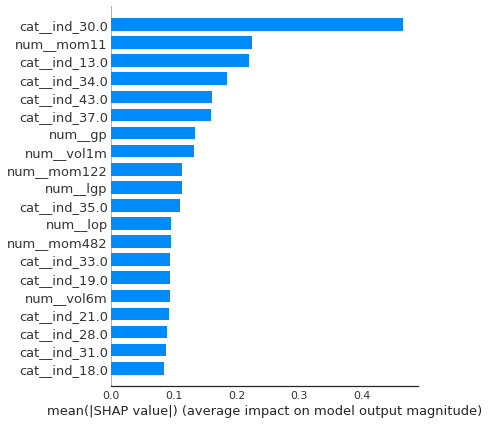

In [93]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [94]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


Min_prd:  650
Constant guess:  7.208431720537165 0.0
XGB test: 6.663347837413472 0.12923565664287784
XGB GS test: 6.526015408868233 0.17990277498412266
Optuna XGB test: 6.610174256287323 0.1524427584789505


In [ ]:
print('Total time for a script: ', time.time()-time0)

In [ ]:
results.iloc[:,1:].mean()

In [ ]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [12]:
display(X_train, X_val, X_test)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
0,2.440252,0.030032,-1.497142,1.080837,0.724789,0.010338,-0.001164,-0.769063,0.061164,-0.521796,-0.613313,0.588274,-0.300375,-0.346009,-0.753732,-0.858156,-0.246214,-0.287970,-2.285884,0.420012,0.545504,-1.453573,-0.079910,0.006677,-0.437054,-0.263244,-0.017419,-0.263946,-0.307586,-0.080405,0.615517,-0.196028,-0.055520,-0.437054,-0.300325,1.723461,-0.612851,-0.587156,-0.248782,-0.897198,-0.999512,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.943299,-0.222745,-1.497142,1.080837,0.724789,0.010338,-0.101503,-0.679058,0.111973,-0.476189,-0.779485,0.796765,0.336568,0.151111,-0.611420,-0.768969,-0.067952,-0.289231,-2.285884,0.420012,0.545504,-1.453573,-0.103939,0.066074,-0.314577,-0.248255,-0.011362,-1.055385,-0.403408,-0.066179,-0.733851,-0.412131,-0.085070,-0.314577,-0.258891,0.909845,-0.555438,-0.378270,-0.329453,-0.907155,-0.987610,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.107274,-0.246470,-1.497142,1.080837,0.724789,0.010338,-0.589553,-0.665144,0.154523,-0.408752,-0.524974,0.808655,-0.458075,-0.365669,-0.517451,-0.719170,-0.391055,-0.327156,-2.285884,0.420012,0.545504,-1.453573,-0.115354,0.117049,0.323205,-0.070163,0.018450,-0.444897,-0.264606,-0.061915,-0.784494,-0.392271,-0.064350,0.323205,-0.377451,0.554145,-0.862790,-0.815012,-0.193126,-0.992504,-0.974490,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.685620,-0.374008,-1.497142,1.080837,0.724789,0.010338,-0.618918,-0.822612,0.211327,-0.498429,-0.506168,0.804064,-0.440318,-0.506501,-0.577175,-0.709441,0.015571,-0.361888,-2.285884,0.420012,0.545504,-1.453573,-0.092495,0.159737,-0.472485,-0.392958,0.078257,-0.321323,-0.249523,0.002885,-0.268268,-0.303054,-0.075501,-0.472485,-0.344694,0.702872,-0.546726,-0.572587,0.058540,-0.900193,-0.950343,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.690976,-0.960773,-1.116726,0.846425,0.659979,-0.425881,-1.749070,-0.921894,0.244523,0.492161,0.500216,0.802548,-0.766582,0.249959,-0.365264,-0.586161,-0.355706,-0.554908,-1.350873,1.033453,0.734261,-0.196466,-0.107086,0.216727,-0.454704,0.013279,0.129583,0.322169,-0.070310,0.009010,-1.065697,-0.400682,-0.079914,-0.454704,-0.286153,0.816731

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
36,-0.447636,1.503621,-0.616017,0.807145,0.566597,-0.676510,0.041370,-0.444748,0.286301,-0.897920,-0.885205,0.669968,-0.996079,-0.899538,-0.823745,-0.714925,-0.357029,-0.373732,-0.394250,-0.569229,-0.440817,0.242727,-0.275573,0.267270,-0.269506,-0.318411,0.205912,-0.104132,-0.331265,0.072720,-0.946680,-0.412905,0.484859,-0.269506,-0.423203,2.672025,-0.595621,-0.602738,0.655205,-0.705329,-0.016263,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,1.082342,2.932444,0.409891,-0.407999,0.054079,-0.291606,-0.494304,2.201976,1.496388,-0.425977,-0.353926,-0.845733,-0.672869,-0.675338,-0.443324,-0.122958,0.004582,-1.042218,0.421057,0.116165,0.326541,-1.125382,-1.573113,1.527156,-0.594924,0.712950,1.761770,-0.679498,0.038660,1.822095,0.159410,0.331043,2.221642,-0.594924,0.995690,1.607994,-0.186524,-0.124067,-2.448014,0.095269,0.861902,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,-0.038815,1.490517,-0.764228,1.661493,1.180223,-0.148263,0.073340,0.476343,0.792124,-1.047382,-0.969301,-1.318185,-1.001774,-1.186375,-1.471881,-1.437878,-0.154287,-0.845688,-0.283119,1.622306,1.928796,-1.026000,-1.010973,0.805248,-0.393897,-0.194811,0.822153,-1.143382,-0.218875,0.889428,-0.854871,-0.437584,1.100826,-0.393897,-0.315926,1.487194,-1.219011,-1.187009,-0.936426,-1.256309,-0.357296,-0.178017,-0.078007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.725718,2.932444,1.004495,-1.707367,-0.945570,-0.468686,1.596658,2.201976,1.897724,1.685851,0.595604,-0.920109,2.095057,1.318192,2.145037,2.084527,-0.322355,-1.567221,1.564946,-2.080395,-1.770265,-0.728135,-2.319771,1.908623,0.307918,0.395609,2.123751,2.460112,0.569178,2.168014,2.476404,4.909389,-0.140420,0.307918,4.010015,2.157728,1.577745,1.776789,3.967493,2.218228,2.230892,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,1.156386,1.442577,-1.101432,1.080693,0.088267,-0.321219,0.139841,0.631494,-2.086450,-1.158357,-1.062442,-0.191328,-0.798725,-0.987976,-1.260964,-1.413439,-0.466201,2.825176,-0.664197,0.890849,-0.008299,0.969864,2.717759,-2.082807,-1.103496,-0.468662,-2.064685,-1.156894,-0.468742,-2.049128,-1.029393,-0.463778,-1.998789,-1.103496,-0.456639,1.337993,-1.117885,-1.

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
37,-0.370711,1.045747,-0.616017,0.807145,0.566597,-0.676510,0.375087,0.151844,0.324364,-0.926429,-0.835087,0.819344,-0.767050,-0.415347,-0.837416,-0.742606,-0.273727,-0.347390,-0.394250,-0.569229,-0.440817,0.242727,-0.416237,0.291945,-1.011197,-0.358964,0.243817,-0.839387,-0.324342,0.095959,-0.731315,-0.357240,0.260356,-1.011197,-0.440167,2.672025,-0.081076,-0.058999,0.166738,-0.602469,-0.391493,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,1.562862,2.932444,0.409891,-0.407999,0.054079,-0.291606,1.619434,1.765912,1.497371,-0.321803,-0.310475,-0.819265,-0.310528,-0.604683,-0.665054,-0.198205,0.019889,-0.948273,0.421057,0.116165,0.326541,-1.125382,-1.415715,1.505979,-0.687561,0.002301,1.688294,-0.429360,0.854002,1.819425,0.480177,0.086252,2.144114,-0.687561,2.133388,2.306243,1.035512,1.048353,-2.348474,0.271762,0.884246,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,-0.017971,1.548951,-0.764228,1.661493,1.180223,-0.148263,0.001117,0.335290,0.784002,-1.173535,-1.074915,-1.418253,-1.138869,-1.358698,-1.498212,-1.529875,-0.196580,-0.841639,-0.283119,1.622306,1.928796,-1.026000,-0.975310,0.799418,-1.016899,-0.156416,0.818801,-0.878843,-0.312308,0.904621,-1.013453,-0.255808,1.068031,-1.016899,-0.067369,1.237983,-0.498111,-0.379121,-1.343626,-1.164610,-0.710352,-0.178017,-0.078007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.995702,2.932444,1.004495,-1.707367,-0.945570,-0.468686,-0.118384,2.201976,1.897724,1.946351,2.146835,-0.986489,1.522755,1.681061,2.134220,2.084527,2.409377,-1.570553,1.564946,-2.080395,-1.770265,-0.728135,-2.259244,1.908623,2.084007,-0.324324,1.933517,1.854294,0.172582,2.168014,2.476404,4.909389,-0.140420,2.084007,3.674272,0.206004,2.463395,2.423646,-0.487464,2.218228,2.230892,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,1.147943,1.282408,-1.101432,1.080693,0.088267,-0.321219,0.057190,0.589992,-2.076221,-1.190013,-1.156021,-0.079273,-0.976936,-0.943820,-1.358742,-1.372436,-0.454743,2.832604,-0.664197,0.890849,-0.008299,0.969864,2.738320,-2.088544,-0.813583,-0.468032,-2.077690,-0.794177,-0.457275,-2.050656,0.040278,-0.467010,-2.036770,-0.813583,-0.457157,1.051903,-1.203442,-1.138

In [13]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

222721


In [104]:
neurons_base = 4
dropout_rate = 0.01

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

3681


In [180]:
neurons_base = 32
l2_reg_rate = 0.1

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn.count_params())

67073


Epoch 1/1000
30/30 - 1s - loss: 166.2244 - mean_squared_error: 123.1386 - val_loss: 172.7545 - val_mean_squared_error: 134.9378
Epoch 2/1000
30/30 - 0s - loss: 154.6469 - mean_squared_error: 120.8503 - val_loss: 160.1106 - val_mean_squared_error: 130.1437
Epoch 3/1000
30/30 - 0s - loss: 146.7836 - mean_squared_error: 119.6482 - val_loss: 156.0668 - val_mean_squared_error: 131.6753
Epoch 4/1000
30/30 - 0s - loss: 141.4286 - mean_squared_error: 119.0860 - val_loss: 152.1978 - val_mean_squared_error: 131.8606
Epoch 5/1000
30/30 - 0s - loss: 137.7179 - mean_squared_error: 118.9093 - val_loss: 146.2824 - val_mean_squared_error: 128.9557
Epoch 6/1000
30/30 - 0s - loss: 135.0744 - mean_squared_error: 118.9021 - val_loss: 143.2238 - val_mean_squared_error: 128.1778
Epoch 7/1000
30/30 - 0s - loss: 132.3937 - mean_squared_error: 118.2304 - val_loss: 142.2088 - val_mean_squared_error: 128.9362
Epoch 8/1000
30/30 - 0s - loss: 130.7082 - mean_squared_error: 118.1584 - val_loss: 139.0246 - val_mean_

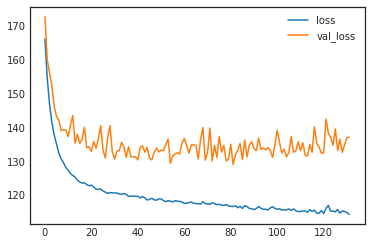

In [181]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [11]:
X_train.skew()

num__mom482       2.014820
num__mom242       1.343044
num__bm           0.122894
num__op          -0.848916
num__gp           0.607772
                   ...    
cat__ind_45.0    19.090080
cat__ind_46.0    79.436081
cat__ind_47.0    12.898892
cat__ind_48.0    20.318332
cat__ind_49.0    13.162803
Length: 92, dtype: float64

In [ ]:
X_val

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [176]:
# classic architecture:

neurons_base = 32
l2_reg_rate = 0.5
he_init = tf.keras.initializers.HeNormal()

model_nn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="elu", kernel_initializer=he_init, 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=neurons_base*4, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(units=neurons_base*2, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(units=neurons_base, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(1)])

print(model_nn.count_params())


68865


Epoch 1/1000
30/30 - 1s - loss: 535.3593 - mean_squared_error: 123.5355 - val_loss: 480.1155 - val_mean_squared_error: 138.7751
Epoch 2/1000
30/30 - 0s - loss: 409.8263 - mean_squared_error: 121.1279 - val_loss: 379.2305 - val_mean_squared_error: 140.5430
Epoch 3/1000
30/30 - 0s - loss: 323.0998 - mean_squared_error: 119.8930 - val_loss: 312.2409 - val_mean_squared_error: 142.4989
Epoch 4/1000
30/30 - 0s - loss: 265.4126 - mean_squared_error: 119.5592 - val_loss: 264.3673 - val_mean_squared_error: 141.3278
Epoch 5/1000
30/30 - 0s - loss: 225.5078 - mean_squared_error: 119.2006 - val_loss: 231.8146 - val_mean_squared_error: 141.6265
Epoch 6/1000
30/30 - 0s - loss: 196.7393 - mean_squared_error: 118.5110 - val_loss: 210.5220 - val_mean_squared_error: 143.8578
Epoch 7/1000
30/30 - 0s - loss: 176.6699 - mean_squared_error: 118.5655 - val_loss: 189.9470 - val_mean_squared_error: 140.0985
Epoch 8/1000
30/30 - 0s - loss: 162.2228 - mean_squared_error: 118.5190 - val_loss: 178.0574 - val_mean_

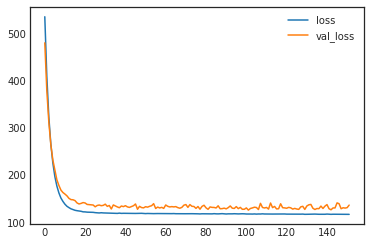

In [177]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_nn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_nn.predict(X_train)), 
       r2_score(y_val, model_nn.predict(X_val)),
       r2_score(y_test, model_nn.predict(X_test))])
print(time.time()-time1)